# District Heating system investment optimization
#### Including 
- CO2 limit to heat emission factor of 180 g/kWh
- simple emission constraint using the built-in oemof module
- investment optimization

## 1) Import required libraries and input data, set boundary conditions

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as po
import seaborn as sns

# here we import the oe9mof libraries. For investment optimization we need the module "economics" fron the oemof tools
from oemof import solph
from oemof.solph import constraints
from oemof.tools import economics

In [2]:
# read data from input csv file into Pandas DataFrame

full_filename = os.path.join('heat_profile_exam_project (1).csv')
input_data = pd.read_csv(full_filename,index_col = 'timestamp')
input_data.index=pd.to_datetime(input_data.index,utc=True)
input_data

,pth_load,price_el,pv_load,Temp
timestamp,,,,
2017-12-31 23:00:00+00:00,0.304666,-5.27,0.0,8.31
2018-01-01 00:00:00+00:00,0.323858,-29.99,0.0,7.85
2018-01-01 01:00:00+00:00,0.310962,-56.65,0.0,7.34
2018-01-01 02:00:00+00:00,0.319773,-63.14,0.0,6.69
2018-01-01 03:00:00+00:00,0.274180,-64.62,0.0,6.27
...,...,...,...,...
2018-12-31 18:00:00+00:00,0.520880,58.28,0.0,3.88
2018-12-31 19:00:00+00:00,0.520796,50.01,0.0,3.70
2018-12-31 20:00:00+00:00,0.462257,45.06,0.0,3.26


In [3]:
input_data.index.freq = 'H'

In [4]:
# set boundary conditions
Pth_load = 5000  # max. heat load in kW
Qth_store = 6939.12 # capacity of heat storage in kWh
Pv_cap = 250 #unit in kW
price_ngas = 100   # gas price in €/MWh
price_grid = 400 # grid costs in €/MWh
price_feedin = 120 # feed in costs in €/MWh
price_gh2 = 174.01 #feed in costs in €/MWh

eta_boiler = 0.93 # efficiency of the boiler 

eta_el_CHP = 0.43 # electrical efficiency of CHP unit
sigma_CHP = 0.98 # power-to-heat ratio CHP

In [5]:
#CO2_limit of the system is defined 
Total_yearly_demand = input_data['pth_load'].sum()
Peak_load = Pth_load 
Heat_demand = Total_yearly_demand * Peak_load
CO2_heat_limit = 180 #unit in g/kWh
CO2_limit = (Heat_demand*CO2_heat_limit)/1000 # units in kg
print("Total Heat in year (kWh/kW):",Total_yearly_demand)
print("Total energy demand (kWh):", Heat_demand)
print('CO2_limit(Kg):',CO2_limit)

Total Heat in year (kWh/kW): 2032.6904147
Total energy demand (kWh): 10163452.0735
CO2_limit(Kg): 1829421.37323


In [6]:
# define emission factors
fCO2_el = 400 # unit g/kWh
fCO2_feedin  = -400 #unit g/kWh
fCO2_ngas = 240 # unit g/kWh
fCO2_H2 = 0 #g/kwh
fCO2_heat = 180 #unit g/kWh
fCO2_PV = 0 #unit g/kWh
# define share of heat pump with regard to the total heat production
hp_tshare = 0.3

In [7]:
#COP submodel
COP_max=3 #highest COP at Higher temperature
COP_min=2.5 #Lowest COP at Lowest temperature
lowest_temp = input_data['Temp'].min() #Lowest temperature in the year
highest_temp = input_data['Temp'].max() #Highest temperature in the year
M =((COP_max - COP_min)/(highest_temp-lowest_temp))
B =(COP_min -(M*lowest_temp))
COP =((M * np.array(input_data['Temp']))+B) #quadratic equation for the submodel of temperature dependent COP of Heat Pump
print("Lowest ambient Temperature :", lowest_temp)
print("Highest ambient Temperature :", highest_temp)
print(COP)

Lowest ambient Temperature : -18.63
Highest ambient Temperature : 31.43
[2.76907711 2.76448262 2.75938873 ... 2.71863763 2.71624051 2.71664003]


In [8]:
# In order to include investment optimization in the model we need to define investment as perdiodical costs
# This can be done by calculating the annuity of the investment using the annuity method from the economics module
epc_boiler = economics.annuity(capex=100, n=20, wacc=0.05)
epc_hp = economics.annuity(capex=1500, n=20, wacc=0.05)
epc_CHP = economics.annuity(capex=750, n=20, wacc=0.05)
epc_PV = economics.annuity(capex=800,n=20,wacc=0.05)
epc_thmstrg = economics.annuity(capex=500, n=20, wacc=0.05)

## 2) Create energy system, define buses, sources, sinks and transformers
### 2.1) Create energy system

In [9]:
# create an energy system
es = solph.EnergySystem(timeindex=input_data.index)

### 2.2) Define buses

In [10]:
# natural gas bus
bhydro = solph.Bus(label='hydrobus')

# CHP electricity bus
bfdin = solph.Bus(label='fdinbus')

# electricity bus
bel = solph.Bus(label='ebus')

# PV bus
bpv = solph.Bus(label='PVbus')

# thermal bus
bth = solph.Bus(label='tbus')

### 2.3) Define sources and sinks

In [11]:
# natural gas supply from public grid
supply_hydro = solph.Source(label='supply_hydro',
                           outputs={bhydro: solph.Flow(variable_costs=price_gh2/1000,
                                                     emission_factor=fCO2_H2/1000)}) 

# Electricity supply from the grid
supply_el = solph.Source(label='public_grid',
                       outputs={bel: solph.Flow(variable_costs=(input_data['price_el']+price_grid)/1000,
                                                emission_factor=fCO2_el/1000)})
#pv
supply_pv = solph.Source(label='PV',
                        outputs={bpv: solph.Flow(fix=input_data['pv_load'],
                                                    nominal_value_PV = Pv_cap,
                                                 emission_factor=fCO2_PV/1000)})
# heat demand
heat_demand = solph.Sink(label='tload',
                         inputs={bth: solph.Flow(fix=input_data['pth_load'],
                                                 nominal_value=Pth_load)})
#feed_in
Feed_in = solph.Sink(label='CHP feed in',
                        inputs={bfdin:solph.Flow(variable_costs=price_feedin/1000,
                                                emission_factor=fCO2_feedin/1000)})

### 2.4) Define transformers and storages
#### Here we include new features: 
- add investment optimization to the heat pump , the boiler and the CHP. 
- define min and max values for the size of components in the investment optimization
- set nonconvex to True in invesment mode for allowing binary optimization for component sizing, i.e. either 0 kW or values between min and max kW

In [12]:
# we need to set the nominal value to "None" to let the optimizer find the optimum value
heatPump = solph.Transformer(label='heat_pump',
                           inputs={bel: solph.Flow()},
                           outputs={bth: solph.Flow(nominal_value=None,
                                                    investment=solph.Investment(ep_costs=epc_hp),
                                                    T_output_flow=True)},
                           conversion_factors={bth: COP})

# boiler 
# we need to set the nominal value to "None" to let the optimizer find the optimum value
boiler = solph.Transformer(label='boiler',
                           inputs={bhydro: solph.Flow()},
                           outputs={bth: solph.Flow(nominal_value=None,
                                                    investment=solph.Investment(ep_costs=epc_boiler),
                                                   T_output_flow=True)},
                           conversion_factors={bhydro: 1/eta_boiler})

# CHP
mCHP = solph.Transformer(label='mCHP',
                         inputs={bhydro: solph.Flow()}, 
                         outputs={bfdin: solph.Flow(nominal_value=None,
                                                    investment=solph.Investment(ep_costs=epc_CHP,
                                                                               maximum=3000,
                                                                               minimum=1000,
                                                                               nonconvex=False)),
                                  bth: solph.Flow(T_output_flow=True)},
                         conversion_factors={bhydro: 1/eta_el_CHP,bth: 1/sigma_CHP})
#PV
tPV =solph.Transformer(label='tPV',
                           inputs={bpv: solph.Flow()},
                           outputs={bel: solph.Flow(nominal_value=None,
                                                    investment = solph.Investment(ep_costs = epc_PV, 
                                                                                  maximum=250,
                                                                                  nonconvex=True))},
                           conversion_factors={bel: 1})

In [13]:
# thermal storage
therm_store = solph.components.GenericStorage(label='storage_thermal',
                                              nominal_storage_capacity=Qth_store,
                                              inputs={bth: solph.Flow()},
                                              outputs={bth: solph.Flow(nominal_value=None,
                                                                       investment=solph.Investment(ep_costs=epc_thmstrg))},
                                              initial_storage_level=0.5,
                                              balanced=True)

### 2.5) Add buses, sources, sinks and transformers to the energy system

In [14]:
# add buses to energy system
es.add(bhydro,bfdin, bel,bpv, bth)

# add sources and sinks to energy system
es.add(supply_hydro, supply_el, supply_pv, Feed_in, heat_demand)

# add transformers to energysystem
es.add(heatPump, boiler,mCHP,tPV, therm_store)

## 3) Build and solve model

### 3.1) Build model

In [15]:
# create model
om = solph.Model(es)

### 3.2) Add constraints

In [16]:
# add the emission constraint
#constraints.emission_limit(om, limit=CO2_limit)

In [17]:
# create pyomo block for defining constraints.
 #the "constr_block" will contain the flows and expressions to be considered for the contraint definitions
constr_block = po.Block()

In [18]:
# create list with flows for emission constraint -> search for all flows including the attribute "emission_factor"
constr_block.INPUTFLOWS = [k for (k, v) in om.flows.items()
                           if hasattr(v, 'emission_factor')]
constr_block.INPUTFLOWS

[("<oemof.solph.network.bus.Bus: 'fdinbus'>",
  "<oemof.solph.network.sink.Sink: 'CHP feed in'>"),
 ("<oemof.solph.network.source.Source: 'supply_hydro'>",
  "<oemof.solph.network.bus.Bus: 'hydrobus'>"),
 ("<oemof.solph.network.source.Source: 'public_grid'>",
  "<oemof.solph.network.bus.Bus: 'ebus'>"),
 ("<oemof.solph.network.source.Source: 'PV'>",
  "<oemof.solph.network.bus.Bus: 'PVbus'>")]

In [19]:
# create list with flows for thermal share -> search for all flows including the attribute "T_output_flow"
constr_block.TFLOWS = [k for (k,v) in om.flows.items()
                       if hasattr(v, 'T_output_flow')]
constr_block.TFLOWS

[("<oemof.solph.network.transformer.Transformer: 'heat_pump'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>"),
 ("<oemof.solph.network.transformer.Transformer: 'boiler'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>"),
 ("<oemof.solph.network.transformer.Transformer: 'mCHP'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>")]

In [20]:
# add the constraints sub-model to the oemof model instance
om.add_component('Constr_Block', constr_block)

In [21]:
# add emission constraint to the constraint block
constr_block.emission_constr = po.Constraint(expr=
                                             (sum(om.flow[i, o, t]*om.flows[i, o].emission_factor 
                                                  for (i, o) in constr_block.INPUTFLOWS
                                                   for t in om.TIMESTEPS) 
                                              <= CO2_limit))

In [22]:
# emission constraint for heat
heat_constr = po.Constraint(expr=
                           (sum(om.flow[i, o, t] * om.flows[i, o].emission_factor 
                                for (i, o) in constr_block.INPUTFLOWS 
                                for t in om.TIMESTEPS 
                                if om.flows[i, o].emission_factor == fCO2_heat) 
                                <= fCO2_heat))

In [23]:
# add thermal share constraint to the constraint block
constr_block.tshare_constr = po.Constraint(expr=
                                            (sum(om.flow[heatPump, bth, t]
                                                 for t in om.TIMESTEPS)
                                             >= hp_tshare * sum(om.flow[i, o, t]
                                                                for (i, o) in constr_block.TFLOWS
                                                                for t in om.TIMESTEPS))) 

### 3.3) Solve model

In [24]:
om.solve(solver='cbc', solve_kwargs={'tee': False})

{'Problem': [{'Name': 'unknown', 'Lower bound': 1230803.49312817, 'Upper bound': 1230803.49312817, 'Number of objectives': 1, 'Number of constraints': 61300, 'Number of variables': 61302, 'Number of binary variables': 1, 'Number of integer variables': 1, 'Number of nonzeros': 26285, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 160.13, 'Wallclock time': 160.13, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 160.18796920776367}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## 4) Retrieve and visualize results

In [25]:
# retrieve results
results = solph.processing.results(om)
res_bth = solph.views.node(results,'tbus')['sequences']
res_bhydro = solph.views.node(results,'hydrobus')['sequences']
res_bel = solph.views.node(results,'ebus')['sequences']
res_fdin = solph.views.node(results,'fdinbus')['sequences']
res_hp = solph.views.node(results,'heat_pump')['sequences']
res_boiler = solph.views.node(results,'boiler')['sequences']
res_chp = solph.views.node(results,'mCHP')['sequences']
res_pv = solph.views.node(results,'tPV')['sequences']

In [26]:
# print size of boiler and heat pump
pth_boiler_res = results[(boiler, bth)]["scalars"]["invest"] 
pth_hp_res = results[(heatPump, bth)]["scalars"]["invest"] 
pel_CHP_res = results[(mCHP, bfdin)]["scalars"]["invest"] 
pel_PV_res = results[(tPV, bel)]["scalars"]["invest"]
print('Optimum nominal thermal power output of boiler: {:.0f} kW'.format(pth_boiler_res))
print('Optimum nominal thermal power output of heat pump: {:.0f} kW'.format(pth_hp_res))
print('Optimum nominal electric/thermal power output of CHP: {:.0f} kWel / {:.0f} kWth'.format(pel_CHP_res,pel_CHP_res/sigma_CHP))
print('Optimum nominal electric power of PV: {:.0f} kW'.format(pel_PV_res))

Optimum nominal thermal power output of boiler: 3264 kW
Optimum nominal thermal power output of heat pump: 715 kW
Optimum nominal electric/thermal power output of CHP: 1000 kWel / 1020 kWth
Optimum nominal electric power of PV: 250 kW


In [41]:
# print total cost and total CO2
print('Total cost {:.2f} €'.format(om.objective()))
print('Total CO2 {:.2f} kg'.format(constr_block.emission_constr()))

hp_t_output = res_bth[(('heat_pump', 'tbus'), 'flow')].sum()
boiler_t_output = res_bth[(('boiler', 'tbus'), 'flow')].sum()
CHP_t_output = res_bth[(('mCHP','tbus'),'flow')].sum()
hp_tshare_res = hp_t_output / (hp_t_output + boiler_t_output+CHP_t_output)
boiler_t_output_res = boiler_t_output / (hp_t_output + boiler_t_output+CHP_t_output)
CHP_t_output_res = CHP_t_output / (hp_t_output + boiler_t_output+CHP_t_output) 
print("Thermal share of the heat pump: {:.1f} %".format(hp_tshare_res*100))
print("Thermal share of the CHP: {:.1f} %".format(boiler_t_output_res*100))
print("Thermal share of the Boiler: {:.1f} %".format(CHP_t_output_res*100))

Total cost 1230803.49 €
Total CO2 17994.79 kg
Thermal share of the heat pump: 47.1 %
Thermal share of the CHP: 52.9 %
Thermal share of the Boiler: 0.1 %


[Text(0, 0.5, 'Thermal Power in kW')]

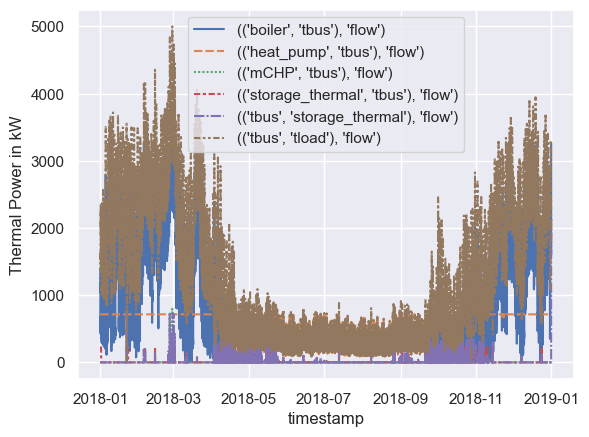

In [28]:
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bth, drawstyle='steps-post')
plot.set(ylabel='Thermal Power in kW')

[Text(0, 0.5, 'Fuel Power in kW')]

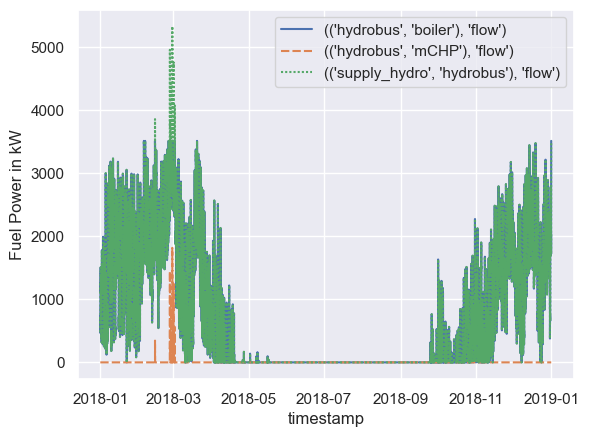

In [29]:
plot = sns.lineplot(data=res_bhydro, drawstyle='steps-post')
plot.set(ylabel='Fuel Power in kW')

[Text(0, 0.5, 'Electric Power in kW')]

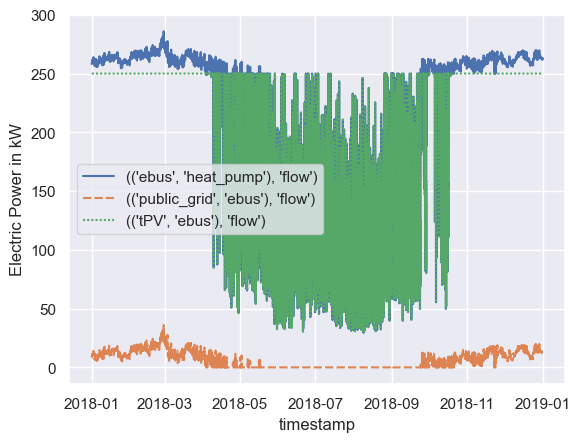

In [30]:
plot = sns.lineplot(data=res_bel, drawstyle='steps-post')
plot.set(ylabel='Electric Power in kW')

[Text(0, 0.5, 'Electric power in kw')]

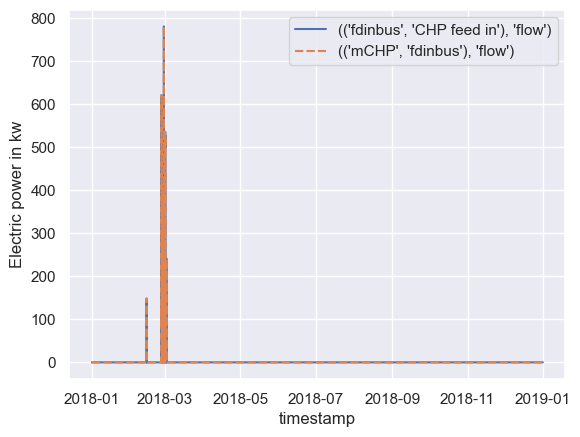

In [31]:
plot =sns.lineplot(data=res_fdin, drawstyle='steps-post')
plot.set(ylabel='Electric power in kw')

[Text(0, 0.5, 'Electric Power in kW')]

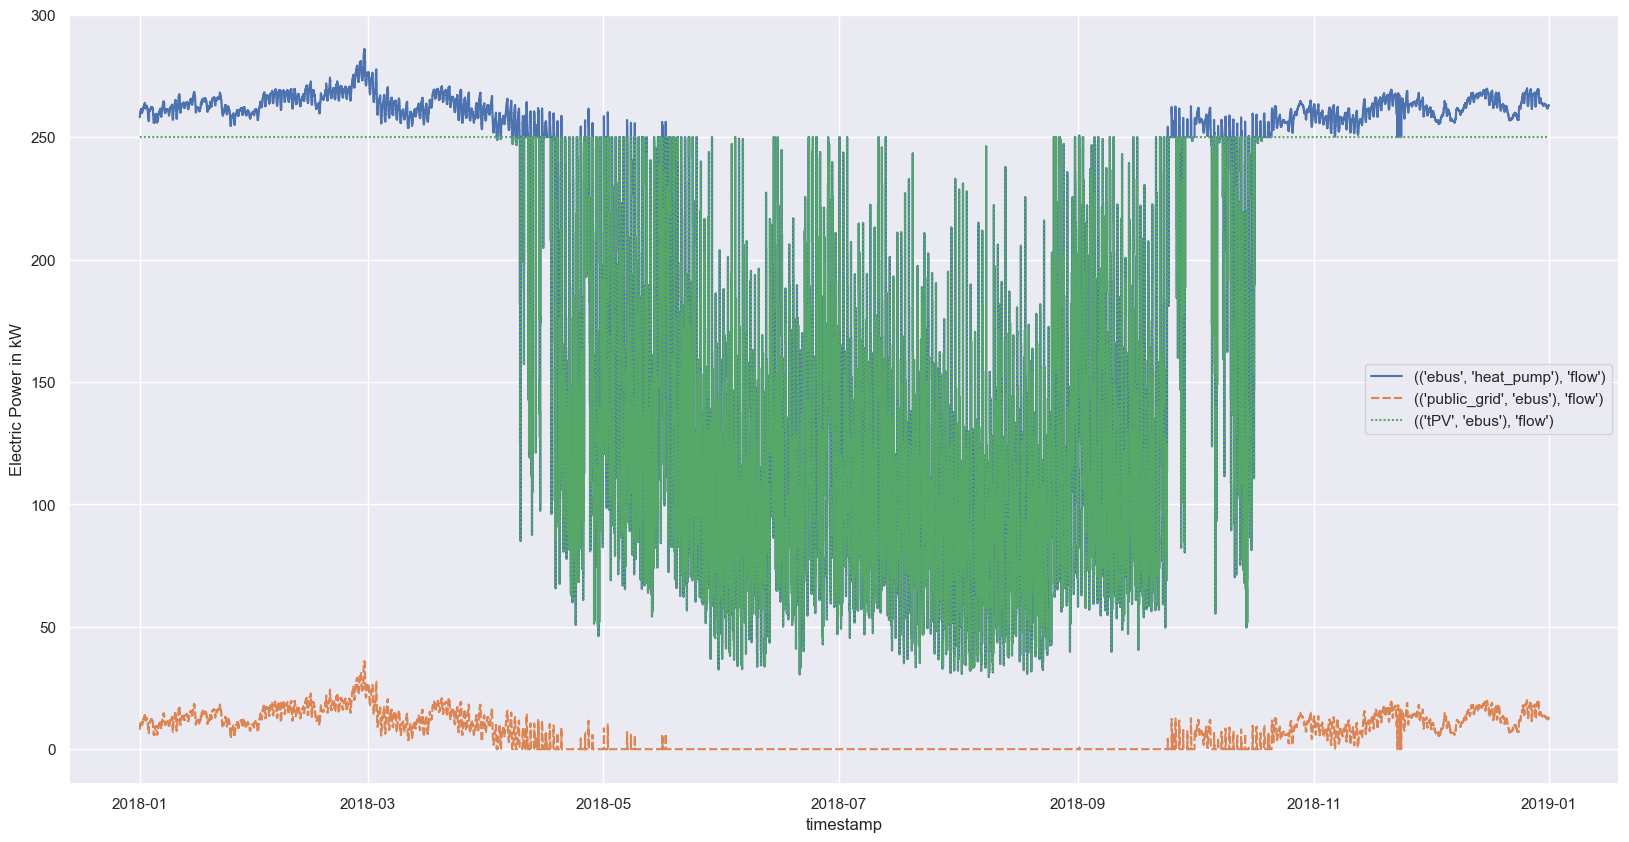

In [32]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bel = solph.views.node(profiles,'ebus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bel, drawstyle='steps-post')
plot.set(ylabel='Electric Power in kW')

[Text(0, 0.5, 'Thermal power in kW')]

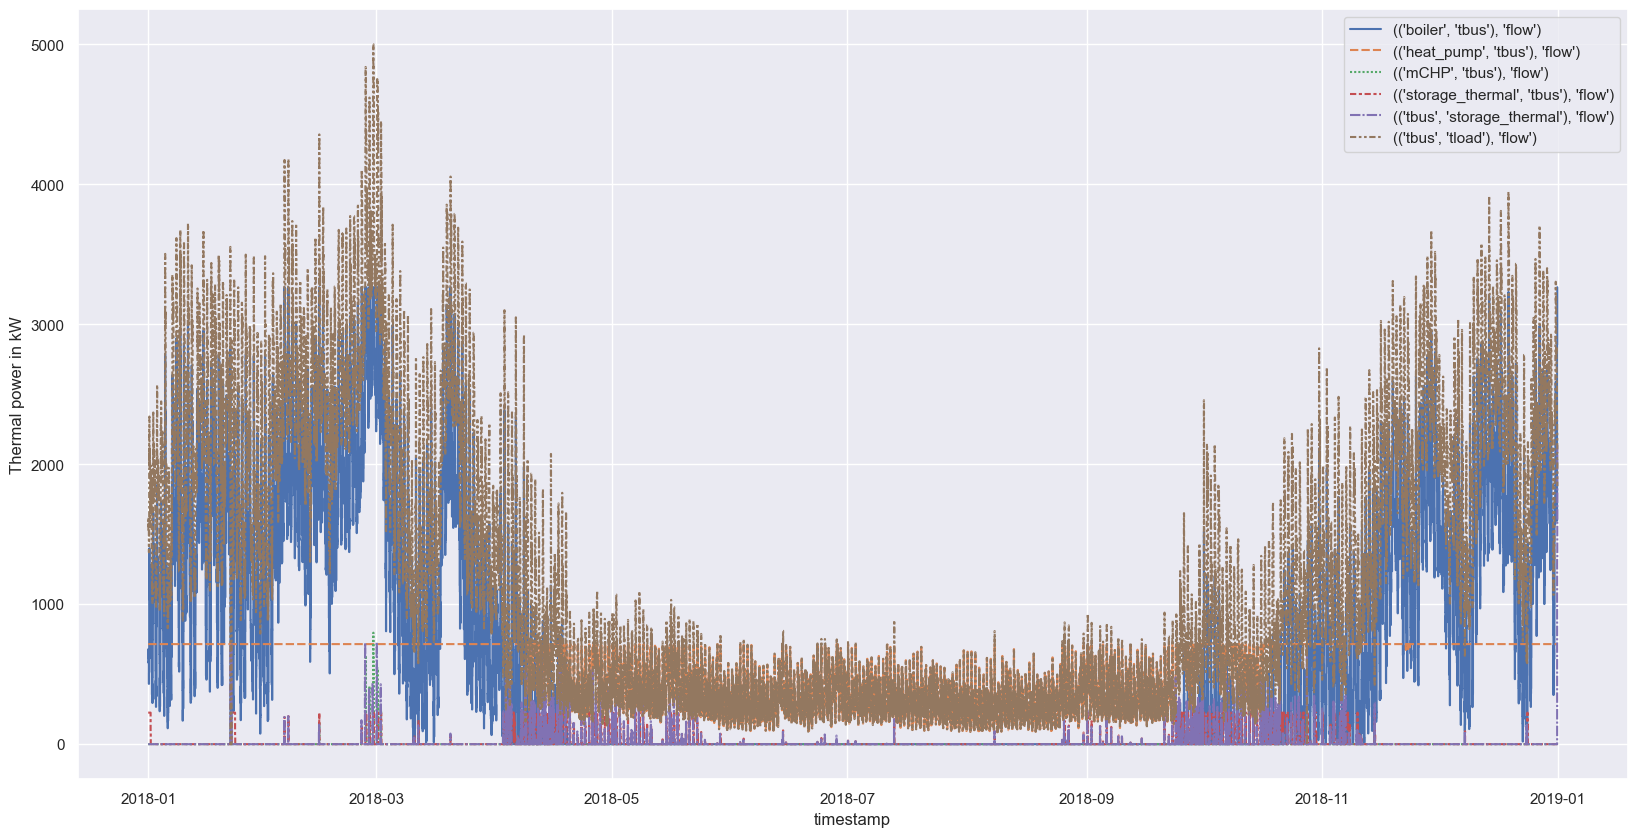

In [40]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bth = solph.views.node(profiles,'tbus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bth, drawstyle='steps-post')
plot.set(ylabel='Thermal power in kW')

[Text(0, 0.5, 'fuel Power in kW')]

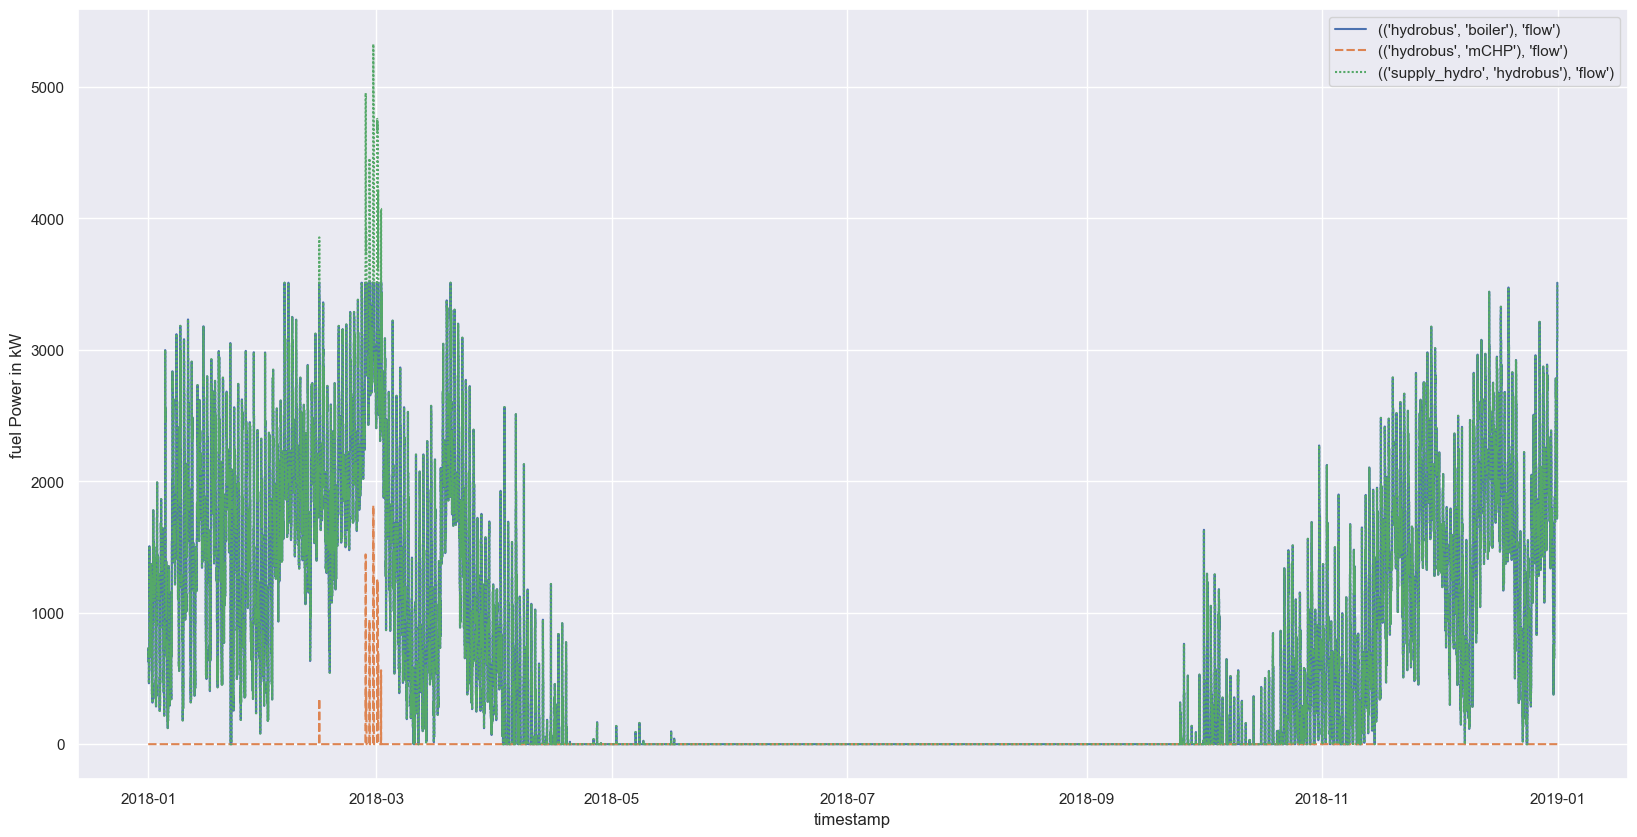

In [39]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bhydro = solph.views.node(profiles,'hydrobus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bhydro, drawstyle='steps-post')
plot.set(ylabel='fuel Power in kW')

[Text(0, 0.5, ' Power in kW')]

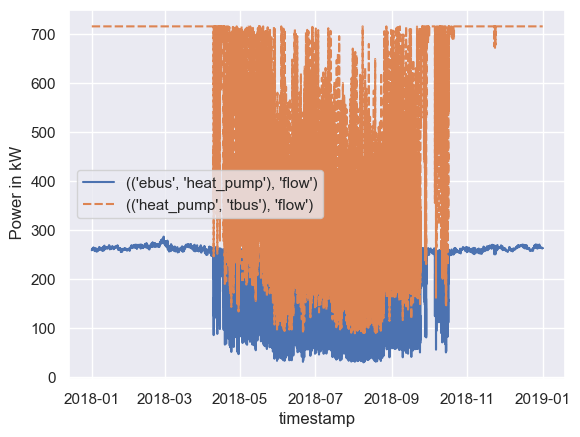

In [35]:
plot = sns.lineplot(data=res_hp, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')

[Text(0, 0.5, ' Power in kW')]

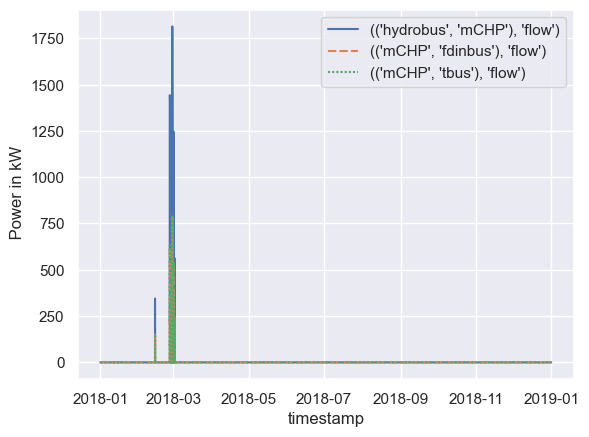

In [36]:
plot = sns.lineplot(data=res_chp, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')

[Text(0, 0.5, ' Power in kW')]

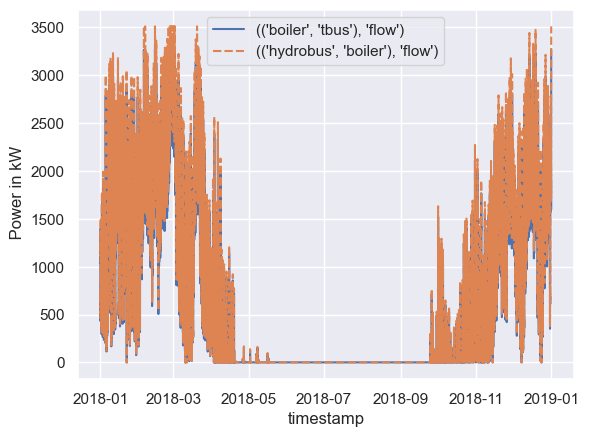

In [37]:
plot = sns.lineplot(data=res_boiler, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')

[Text(0, 0.5, ' Power in kW')]

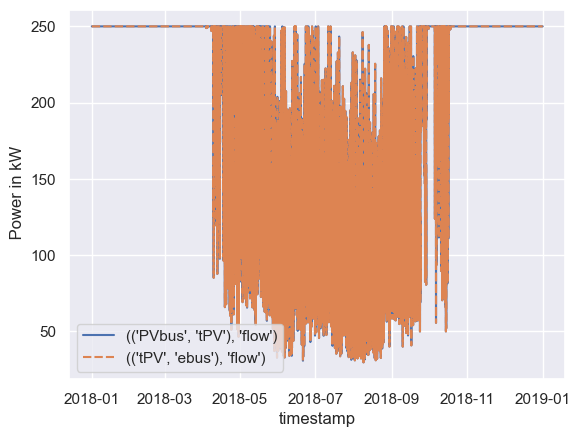

In [38]:
plot = sns.lineplot(data=res_pv, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')